# Perform Data Preprocessing, QC, and cNMF for sample 3: 'WholeMes_Col' 
Counts are data from 210505 <br>
h5ad and cNMF files are uploaded to: Shivdasani2022/220624_sample3-WholeMes_SInt/


## Environment Setup (220501)
Install software from pip, apt, and Github.  Load modules, configure workspace settings.

### Install Python Software

In [ ]:
!python --version

Python 3.7.13


In [ ]:
# As of May 2022, cNMF requires these specific versions of fastcluster and pyyaml
!pip install -q scanpy==1.8.2 leidenalg==0.8.10 scrublet==0.2.3 wget==3.2 
!pip install -q pyyaml==5.3.1 fastcluster==1.1.26 cnmf==1.3.2

     |████████████████████████████████| 2.0 MB 7.4 MB/s 
     |████████████████████████████████| 1.3 MB 40.8 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 96 kB 4.3 MB/s 
     |████████████████████████████████| 3.1 MB 65.1 MB/s 
     |████████████████████████████████| 646 kB 64.7 MB/s 
     |████████████████████████████████| 1.1 MB 63.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 269 kB 13.4 MB/s 
     |████████████████████████████████| 155 kB 49.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# We use lftp to upload results files to our lab Box server
!sudo apt-get install -qq lftp

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package netbase.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../archives/netbase_5.4_all.deb ...
Unpacking netbase (5.4) ...
Selecting previously unselected package lftp.
Preparing to unpack .../lftp_4.8.1-1ubuntu0.2_amd64.deb ...
Unpacking lftp (4.8.1-1ubuntu0.2) ...
Setting up netbase (5.4) ...
Setting up lftp (4.8.1-1ubuntu0.2) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for

Kernal restart can be invoked, if necessary, to reload current package versions.

In [ ]:
# Restart Runtime 
#import os
#os.kill(os.getpid(), 9)

### Load Python packages and configure some global settings


In [ ]:
# Import Python packages
import os, sys, wget, pickle
import scrublet as scr
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from cnmf import cNMF

# Don't limit pandas column #
pd.options.display.max_columns=None

Install packages from Github

In [ ]:
# Clone our own custom Python functions from Github 
if not os.path.exists('scTools-py'): 
    !git clone https://github.com/wagnerde/scTools-py.git
sys.path.append('scTools-py/')
import scTools_dew as dew

Cloning into 'scTools-py'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 239 (delta 80), reused 83 (delta 69), pack-reused 143
Receiving objects: 100% (239/239), 66.87 KiB | 16.72 MiB/s, done.
Resolving deltas: 100% (143/143), done.


## Preprocessing

#### Download raw files and import into AnnData

In [ ]:
!mkdir -p /content/Shiv2021Counts/
!wget https://ucsf.box.com/shared/static/r83lhqa3zp72itbw99b6ekatvr9iln7w.zip -O /content/Shiv2021Counts/WT_colon_Mesenchyme_Mm10_raw_feature_bc_matrix.zip
!unzip /content/Shiv2021Counts/WT_colon_Mesenchyme_Mm10_raw_feature_bc_matrix.zip -d /content/Shiv2021Counts/
!gunzip /content/Shiv2021Counts/features.tsv.gz
!gunzip /content/Shiv2021Counts/barcodes.tsv.gz

--2022-06-25 00:57:09--  https://ucsf.box.com/shared/static/r83lhqa3zp72itbw99b6ekatvr9iln7w.zip
Resolving ucsf.box.com (ucsf.box.com)... 185.235.236.197
Connecting to ucsf.box.com (ucsf.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/r83lhqa3zp72itbw99b6ekatvr9iln7w.zip [following]
--2022-06-25 00:57:09--  https://ucsf.box.com/public/static/r83lhqa3zp72itbw99b6ekatvr9iln7w.zip
Reusing existing connection to ucsf.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ucsf.app.box.com/public/static/r83lhqa3zp72itbw99b6ekatvr9iln7w.zip [following]
--2022-06-25 00:57:10--  https://ucsf.app.box.com/public/static/r83lhqa3zp72itbw99b6ekatvr9iln7w.zip
Resolving ucsf.app.box.com (ucsf.app.box.com)... 185.235.236.201
Connecting to ucsf.app.box.com (ucsf.app.box.com)|185.235.236.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxc

In [ ]:
# Load into ScanPy
Shiv2022_WholeMes_Col = sc.read_mtx('/content/Shiv2021Counts/matrix.mtx.gz').transpose()
Shiv2022_WholeMes_Col.var_names = np.loadtxt('/content/Shiv2021Counts/features.tsv', dtype='str', usecols=1)
Shiv2022_WholeMes_Col.obs['unique_cell_id'] = np.loadtxt('/content/Shiv2021Counts/barcodes.tsv', dtype='str')
Shiv2022_WholeMes_Col.var_names_make_unique()
Shiv2022_WholeMes_Col

AnnData object with n_obs × n_vars = 6794880 × 31053
    obs: 'unique_cell_id'

#### Cell Barcode Abundance Filtering

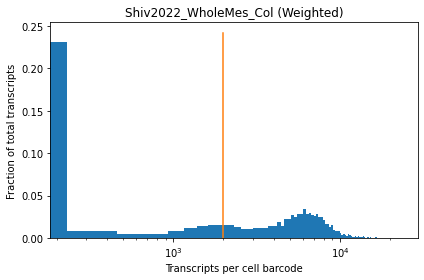

Filtering barcodes for Shiv2022_WholeMes_Col  ( 5278 / 6794880 )


AnnData object with n_obs × n_vars = 5278 × 31053
    obs: 'unique_cell_id', 'n_counts', 'n_genes'

In [ ]:
# Perform barcode filtering
dew.filter_abundant_barcodes(Shiv2022_WholeMes_Col, filter_cells=True, logscale=False, threshold=2000, library_name='Shiv2022_WholeMes_Col')

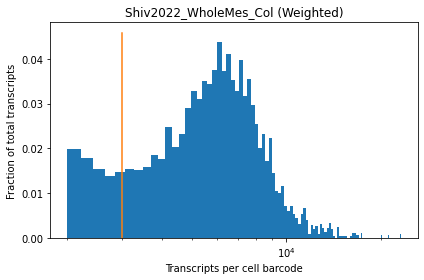

Filtering barcodes for Shiv2022_WholeMes_Col  ( 4344 / 5278 )


AnnData object with n_obs × n_vars = 4344 × 31053
    obs: 'unique_cell_id', 'n_counts', 'n_genes'

In [ ]:
dew.filter_abundant_barcodes(Shiv2022_WholeMes_Col, filter_cells=True, logscale=False, threshold=3000, library_name='Shiv2022_WholeMes_Col')

#### Cell Doublet Filtering

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 50.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.2%
Elapsed time: 6.3 seconds
Doublet-like Cells = 157


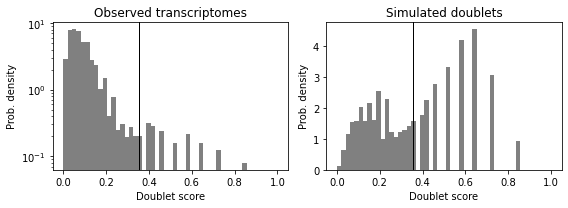

In [ ]:
# Identify and putative doublets and plot doublet scores
np.random.seed(802) # set random seed for reproducibility
scrub = scr.Scrublet(Shiv2022_WholeMes_Col.X, expected_doublet_rate=0.1)
Shiv2022_WholeMes_Col.obs['doublet_scores'], Shiv2022_WholeMes_Col.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram();
print("Doublet-like Cells = {:d}" .format(sum(Shiv2022_WholeMes_Col.obs['predicted_doublets'])))

Detected doublet rate = 9.5%
Estimated detectable doublet fraction = 71.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.3%
Doublet-like Cells = 411


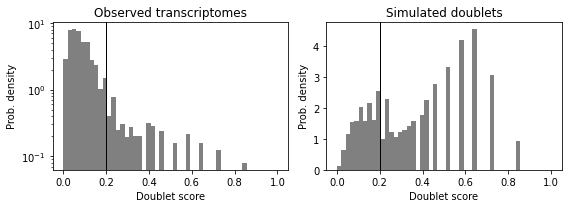

In [ ]:
# Adjust doublet score threshold 
Shiv2022_WholeMes_Col.obs['predicted_doublets'] = scrub.call_doublets(threshold=0.2)
fg,ax = scrub.plot_histogram();
print("Doublet-like Cells = {:d}" .format(sum(Shiv2022_WholeMes_Col.obs['predicted_doublets'])))
fg.savefig('./scrublet_Shiv2022_WholeMes_Col_hist.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


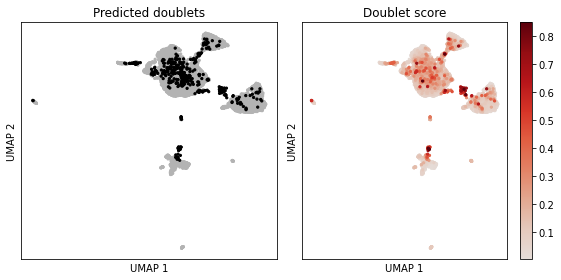

In [ ]:
# Overlay doublet scores on a quick UMAP embedding 
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, n_neighbors=20, min_dist=0.2))
fg,ax = scrub.plot_embedding('UMAP', order_points=True);
fg.savefig('./scrublet_Shiv2022_WholeMes_Col_umap.png', bbox_inches='tight')

In [ ]:
# Remove doublets from the AnnData object 
print("Total Cells = {:d}" .format(len(Shiv2022_WholeMes_Col)))
print("Doublet-like Cells = {:d}" .format(sum(Shiv2022_WholeMes_Col.obs['predicted_doublets'])))
print("Non-Doublet Cells = {:d}" .format(len(Shiv2022_WholeMes_Col) - sum(Shiv2022_WholeMes_Col.obs['predicted_doublets'])))
Shiv2022_WholeMes_Col = Shiv2022_WholeMes_Col[~Shiv2022_WholeMes_Col.obs['predicted_doublets'],:]
Shiv2022_WholeMes_Col

Total Cells = 4344
Doublet-like Cells = 411
Non-Doublet Cells = 3933


View of AnnData object with n_obs × n_vars = 3933 × 31053
    obs: 'unique_cell_id', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets'

#### Mito Filtering

In [ ]:
# annotate the group of mitochondrial genes as 'mt'
Shiv2022_WholeMes_Col.var['mt'] = Shiv2022_WholeMes_Col.var_names.str.startswith('mt-')  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  


In [ ]:
# calculate cell metrics
sc.pp.calculate_qc_metrics(Shiv2022_WholeMes_Col, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

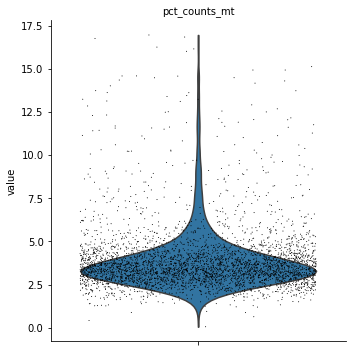

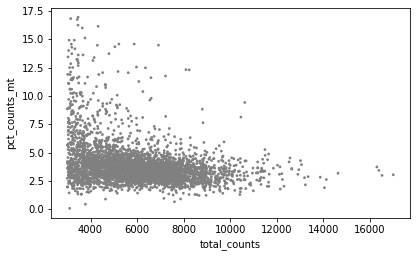

In [ ]:
# explore the distribution of high mt count cells
sc.pl.violin(Shiv2022_WholeMes_Col, ['pct_counts_mt'], jitter=0.4, ylabel=' ', multi_panel=True)
sc.pl.scatter(Shiv2022_WholeMes_Col, x='total_counts', y='pct_counts_mt')

In [ ]:
# Looks like the mito fraction has already been trimmed.  At least for now we won't trim any further.
Shiv2022_WholeMes_Col = Shiv2022_WholeMes_Col[Shiv2022_WholeMes_Col.obs.pct_counts_mt < 6, :]
Shiv2022_WholeMes_Col

View of AnnData object with n_obs × n_vars = 3639 × 31053
    obs: 'unique_cell_id', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#### Save to h5ad

In [ ]:
Shiv2022_WholeMes_Col.raw = Shiv2022_WholeMes_Col.copy()
Shiv2022_WholeMes_Col.X = Shiv2022_WholeMes_Col.X.astype(np.float64) # float64 datatype required for compatibility with cNMF!
Shiv2022_WholeMes_Col.write('Shiv2022_WholeMes_Col_raw.220624.h5ad')

## Perform cNMF

In [ ]:
# cNMF settings (modify as needed)
cNMF_n_iter = 100 
cNMF_n_var_genes = 2000 
cNMF_output_dir = './cNMF-output'
cNMF_run_name = 'Shiv2022-cNMF'
cNMF_k_range = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
cNMF_rand_seed = 14 
cNMF_input_data = 'Shiv2022_WholeMes_Col_raw.220624.h5ad' 

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:843: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


[Worker 0]. Starting task 845.
[Worker 0]. Starting task 846.
[Worker 0]. Starting task 847.
[Worker 0]. Starting task 848.
[Worker 0]. Starting task 849.
[Worker 0]. Starting task 850.
[Worker 0]. Starting task 851.
[Worker 0]. Starting task 852.
[Worker 0]. Starting task 853.
[Worker 0]. Starting task 854.
[Worker 0]. Starting task 855.
[Worker 0]. Starting task 856.
[Worker 0]. Starting task 857.
[Worker 0]. Starting task 858.
[Worker 0]. Starting task 859.
[Worker 0]. Starting task 860.
[Worker 0]. Starting task 861.
[Worker 0]. Starting task 862.
[Worker 0]. Starting task 863.
[Worker 0]. Starting task 864.
[Worker 0]. Starting task 865.
[Worker 0]. Starting task 866.
[Worker 0]. Starting task 867.
[Worker 0]. Starting task 868.
[Worker 0]. Starting task 869.
[Worker 0]. Starting task 870.
[Worker 0]. Starting task 871.
[Worker 0]. Starting task 872.
[Worker 0]. Starting task 873.
[Worker 0]. Starting task 874.
[Worker 0]. Starting task 875.
[Worker 0]. Starting task 876.
[Worker 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


[Worker 0]. Starting task 917.
[Worker 0]. Starting task 918.
[Worker 0]. Starting task 919.
[Worker 0]. Starting task 920.
[Worker 0]. Starting task 921.
[Worker 0]. Starting task 922.
[Worker 0]. Starting task 923.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


[Worker 0]. Starting task 924.
[Worker 0]. Starting task 925.
[Worker 0]. Starting task 926.
[Worker 0]. Starting task 927.
[Worker 0]. Starting task 928.
[Worker 0]. Starting task 929.
[Worker 0]. Starting task 930.
[Worker 0]. Starting task 931.
[Worker 0]. Starting task 932.
[Worker 0]. Starting task 933.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


[Worker 0]. Starting task 934.
[Worker 0]. Starting task 935.
[Worker 0]. Starting task 936.
[Worker 0]. Starting task 937.
[Worker 0]. Starting task 938.
[Worker 0]. Starting task 939.
[Worker 0]. Starting task 940.
[Worker 0]. Starting task 941.
[Worker 0]. Starting task 942.
[Worker 0]. Starting task 943.
[Worker 0]. Starting task 944.
[Worker 0]. Starting task 945.
[Worker 0]. Starting task 946.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


[Worker 0]. Starting task 947.
[Worker 0]. Starting task 948.
[Worker 0]. Starting task 949.
[Worker 0]. Starting task 950.
[Worker 0]. Starting task 951.
[Worker 0]. Starting task 952.
[Worker 0]. Starting task 953.
[Worker 0]. Starting task 954.
[Worker 0]. Starting task 955.
[Worker 0]. Starting task 956.
[Worker 0]. Starting task 957.
[Worker 0]. Starting task 958.
[Worker 0]. Starting task 959.
[Worker 0]. Starting task 960.
[Worker 0]. Starting task 961.
[Worker 0]. Starting task 962.
[Worker 0]. Starting task 963.
[Worker 0]. Starting task 964.
[Worker 0]. Starting task 965.
[Worker 0]. Starting task 966.
[Worker 0]. Starting task 967.
[Worker 0]. Starting task 968.
[Worker 0]. Starting task 969.
[Worker 0]. Starting task 970.
[Worker 0]. Starting task 971.
[Worker 0]. Starting task 972.
[Worker 0]. Starting task 973.
[Worker 0]. Starting task 974.
[Worker 0]. Starting task 975.
[Worker 0]. Starting task 976.
[Worker 0]. Starting task 977.
[Worker 0]. Starting task 978.
[Worker 

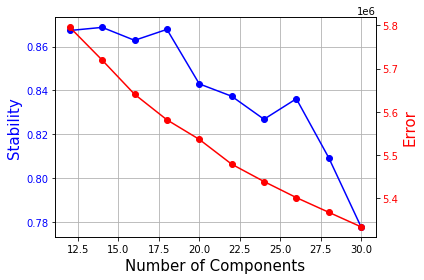

In [ ]:
# Run the Prepare, Factorize, and Combine commands
cnmf_obj = cNMF(output_dir=cNMF_output_dir, name=cNMF_run_name)
cnmf_obj.prepare(counts_fn=cNMF_input_data, num_highvar_genes=cNMF_n_var_genes, components=cNMF_k_range, n_iter=cNMF_n_iter, seed=cNMF_rand_seed)
cnmf_obj.factorize(worker_i=0, total_workers=1)
cnmf_obj.combine()
cnmf_obj.k_selection_plot()

/usr/local/lib/python3.7/dist-packages/cnmf/cnmf.py:700: RuntimeWarning: invalid value encountered in true_divide
  norm_tpm = (np.array(tpm.X.todense()) - tpm_stats['__mean'].values) / tpm_stats['__std'].values


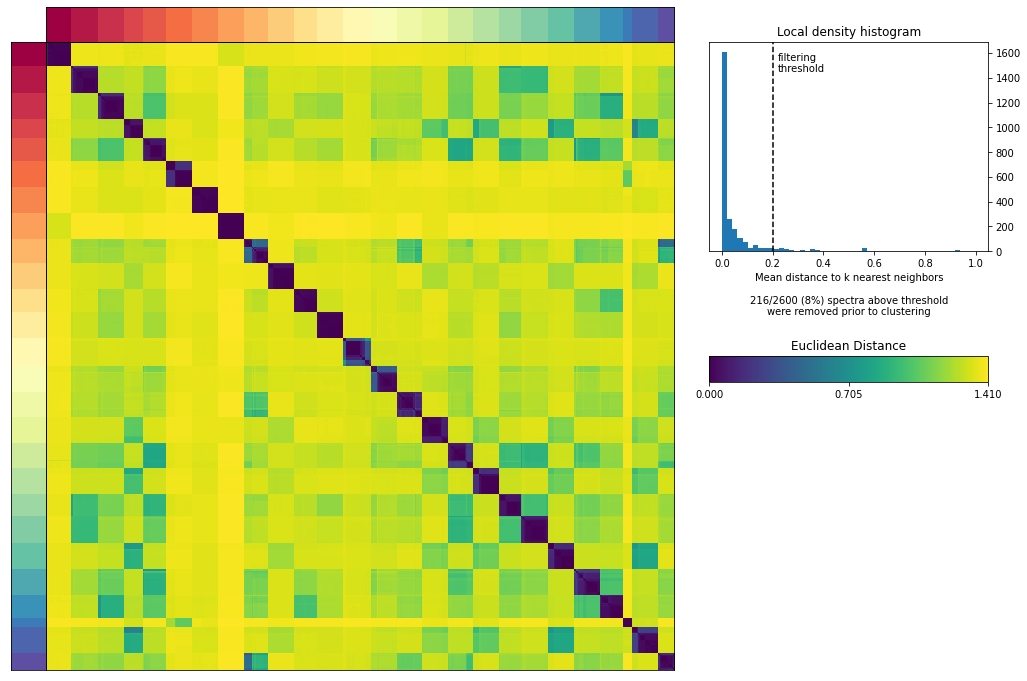

In [ ]:
# Choose consensus parameters (modify as needed)
cNMF_k = 26
cNMF_density_thresh = 0.2
cNMF_local_neighborhood_size = 0.3

# Run Consensus 
cnmf_obj.consensus(k=cNMF_k, density_threshold=cNMF_density_thresh, local_neighborhood_size=cNMF_local_neighborhood_size)

## Upload Results to BOX

In [ ]:
# Create a folder containing the h5ad and cNMF results
!mkdir -p upload_to_Box
!cp -r /content/Shiv2022_WholeMes_Col_raw.220624.h5ad /content/upload_to_Box/ 
!tar -czf /content/upload_to_Box/Shiv2022_WholeMes_Col.220624.cNMF.tar.gz /content/cNMF-output/

In [ ]:
# Prepare LFTP shell command
local_dir = '/content/upload_to_Box/'
remote_box_dir = '/Box_Home/WAGNER_LAB_SHARED/Dan_Wagner/ANALYSES/Shivdasani2022/220624_sample3-WholeMes_Col/'
box_username = 'XXX,XXX' 

lftp_cmd = 'lftp -e "mirror -R %s %s; bye" -u %s ftps://ftp.box.com' % (local_dir, remote_box_dir, box_username)

# Execute shell command
print('Executing:\n %s' % (lftp_cmd))
! {lftp_cmd}